In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [12, 6]

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from data_views import get_trip_and_history_tables

In [2]:
trip_features, leg_history = get_trip_and_history_tables()
trip_features.head()

,current_time,headway,monday,tuesday,wednesday,thursday,friday,saturday,sunday,to_target
half_trip_id,,,,,,,,,,
41926539.0,29209,988.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,319
41926541.0,34603,1430.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,443
41926543.0,40696,2281.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,361
41926545.0,47240,1268.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,487
41926547.0,53741,952.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,309


In [3]:
leg_history.head()

,to_maput,to_cntsq,to_mit,to_hynes,to_masta
half_trip_id,,,,,
41926539.0,181,176,173,161,130
41926541.0,289,220,288,275,352
41926543.0,419,279,230,277,168
41926545.0,303,232,262,322,232
41926547.0,364,157,245,258,269


# Loading into pytorch

In [4]:
target_col = "to_target"

trip_train = trip_features.sample(frac=.7)
trip_test = trip_features.loc[~trip_features.index.isin(trip_train.index)]

y_train = trip_train.pop(target_col).to_numpy().astype('float32')
y_test = trip_test.pop(target_col).to_numpy().astype('float32')

x_trip_train = trip_train.to_numpy().astype('float32')
x_trip_test = trip_test.to_numpy().astype('float32')

In [5]:
def get_normalizer(data):
    means = data.mean(axis=0)
    std = data.std(axis=0)
    return lambda d: (d-means) / std

normalizer = get_normalizer(x_trip_train)
x_trip_train = normalizer(x_trip_train)
x_trip_test = normalizer(x_trip_test)

In [6]:
leg_history_np = leg_history.to_numpy().astype('float32')

# normalize values
leg_history_np = (leg_history_np - leg_history_np.mean()) / leg_history_np.std()

hist_train = leg_history_np[trip_features.index.isin(trip_train.index)]
hist_test = leg_history_np[~trip_features.index.isin(trip_train.index)]

In [7]:
train = data.TensorDataset(
    torch.from_numpy(x_trip_train),
    torch.from_numpy(hist_train),
    torch.from_numpy(y_train).reshape(-1, 1)
)

test = data.TensorDataset(
    torch.from_numpy(x_trip_test),
    torch.from_numpy(hist_test),
    torch.from_numpy(y_test).reshape(-1, 1)
)

train_dl = data.DataLoader(train, batch_size=16, shuffle=True)
test_dl = data.DataLoader(test, batch_size=16)

In [8]:
train[0]

(tensor([-0.9431, -0.0653, -0.4295, -0.4345, -0.4272, -0.4244,  2.3414, -0.3889,
         -0.3199]),
 tensor([-1.2547, -1.2946, -1.3185, -1.4143, -1.6618]),
 tensor([579.]))

# Experiments

In [9]:
class HistoryEncoder(nn.Module):

    def __init__(self, num_stops, output_size):
        super(HistoryEncoder, self).__init__()
        self.num_stops = num_stops
        self.output_size = output_size
        
        self.fc1 = nn.Linear(self.num_stops, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc2 = nn.Linear(16, 16)

        self.fc3 = nn.Linear(16, self.output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        
class Predictor(nn.Module):

    def __init__(self, min_history=1, max_history=5, encoding_size=3):
        super(Predictor, self).__init__()
        
        self.min_history = min_history
        self.max_history = max_history
        self.encoding_size = encoding_size
        
        self.encoders = nn.ModuleList([
            HistoryEncoder(i, self.encoding_size) 
            for i in range(self.min_history, self.max_history+1)
        ])
        
        self.trip_input_size = 9
        self.fc1 = nn.Linear(self.encoding_size + self.trip_input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, trip, hist):
        hist_length = hist.size()[1]
        assert self.min_history <= hist_length <= self.max_history
        
        encoded_hist = self.encoders[hist_length-1](hist)
                
        x = torch.cat([trip, encoded_hist], axis=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(Predictor())

Predictor(
  (encoders): ModuleList(
    (0): HistoryEncoder(
      (fc1): Linear(in_features=1, out_features=16, bias=True)
      (fc2): Linear(in_features=16, out_features=16, bias=True)
      (fc3): Linear(in_features=16, out_features=3, bias=True)
    )
    (1): HistoryEncoder(
      (fc1): Linear(in_features=2, out_features=16, bias=True)
      (fc2): Linear(in_features=16, out_features=16, bias=True)
      (fc3): Linear(in_features=16, out_features=3, bias=True)
    )
    (2): HistoryEncoder(
      (fc1): Linear(in_features=3, out_features=16, bias=True)
      (fc2): Linear(in_features=16, out_features=16, bias=True)
      (fc3): Linear(in_features=16, out_features=3, bias=True)
    )
    (3): HistoryEncoder(
      (fc1): Linear(in_features=4, out_features=16, bias=True)
      (fc2): Linear(in_features=16, out_features=16, bias=True)
      (fc3): Linear(in_features=16, out_features=3, bias=True)
    )
    (4): HistoryEncoder(
      (fc1): Linear(in_features=5, out_features=16, bi

In [36]:
class SingleEncoder(nn.Module):
    def __init__(self, encoding_size=3):
        super(SingleEncoder, self).__init__()
        
        self.encoding_size = encoding_size
        self.encoder = HistoryEncoder(5, self.encoding_size)
        
        self.trip_input_size = 9
        self.fc1 = nn.Linear(self.encoding_size + self.trip_input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, trip, hist):        
        encoded_hist = self.encoder(hist)
        x = torch.cat([trip, encoded_hist], axis=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(SingleEncoder())

SingleEncoder(
  (encoder): HistoryEncoder(
    (fc1): Linear(in_features=5, out_features=16, bias=True)
    (fc2): Linear(in_features=16, out_features=16, bias=True)
    (fc3): Linear(in_features=16, out_features=3, bias=True)
  )
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [98]:
class NoEncoder(nn.Module):
    def __init__(self, hist_input_size=5):
        super(NoEncoder, self).__init__()
        
        self.hist_input_size = hist_input_size
        self.trip_input_size = 9
        self.fc1 = nn.Linear(self.hist_input_size + self.trip_input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, trip, hist):        
        x = torch.cat([trip, hist], axis=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(NoEncoder())

NoEncoder(
  (fc1): Linear(in_features=14, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)


In [32]:
def run_loop(model, dl, loss_func, step=False, optimizer=None, min_history=1, max_history=5):
    total_loss = 0
    for trip, hist, y in dl:
        hist_length = random.randint(min_history, max_history)
        pred = model(trip, hist[:, :hist_length])
        loss = loss_func(pred, y)

        if step:
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        total_loss += loss

    return (total_loss / len(dl)).item()

In [33]:
model = Predictor()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
mse = nn.SmoothL1Loss(beta=100)

epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = run_loop(model, train_dl, mse, step=True, optimizer=opt)
    
    model.eval()
    with torch.no_grad():
        valid_loss = run_loop(model, test_dl, mse)

        print(f"Epoch {epoch}:\t training loss: {train_loss:,.1f}\t test loss: {valid_loss:,.1f}")

Epoch 0:	 training loss: 133.4	 test loss: 91.2
Epoch 1:	 training loss: 93.3	 test loss: 93.4
Epoch 2:	 training loss: 92.9	 test loss: 89.6
Epoch 3:	 training loss: 92.7	 test loss: 89.1
Epoch 4:	 training loss: 92.6	 test loss: 92.7
Epoch 5:	 training loss: 92.4	 test loss: 86.3
Epoch 6:	 training loss: 92.3	 test loss: 91.9
Epoch 7:	 training loss: 92.2	 test loss: 90.8
Epoch 8:	 training loss: 92.1	 test loss: 92.1
Epoch 9:	 training loss: 92.0	 test loss: 91.0


In [54]:
model = SingleEncoder()
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
mse = nn.SmoothL1Loss(beta=100)

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = run_loop(model, train_dl, mse, step=True, optimizer=opt, min_history=5)
    
    model.eval()
    with torch.no_grad():
        valid_loss = run_loop(model, test_dl, mse, min_history=5)

        print(f"Epoch {epoch}:\t training loss: {train_loss:,.1f}\t test loss: {valid_loss:,.1f}")

Epoch 0:	 training loss: 103.0	 test loss: 87.1
Epoch 1:	 training loss: 94.8	 test loss: 90.5
Epoch 2:	 training loss: 94.0	 test loss: 97.7
Epoch 3:	 training loss: 93.1	 test loss: 90.5
Epoch 4:	 training loss: 93.0	 test loss: 89.6
Epoch 5:	 training loss: 84.7	 test loss: 64.7
Epoch 6:	 training loss: 64.9	 test loss: 59.9
Epoch 7:	 training loss: 62.1	 test loss: 59.9
Epoch 8:	 training loss: 61.6	 test loss: 60.0
Epoch 9:	 training loss: 60.9	 test loss: 58.4
Epoch 10:	 training loss: 60.9	 test loss: 61.0
Epoch 11:	 training loss: 60.6	 test loss: 60.4
Epoch 12:	 training loss: 60.4	 test loss: 58.3
Epoch 13:	 training loss: 60.3	 test loss: 57.7
Epoch 14:	 training loss: 60.3	 test loss: 58.2


In [100]:
noEnc = NoEncoder()
opt = torch.optim.Adam(noEnc.parameters(), lr=1e-2)
mse = nn.SmoothL1Loss(beta=100)

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = run_loop(noEnc, train_dl, mse, step=True, optimizer=opt, min_history=5)
    
    model.eval()
    with torch.no_grad():
        valid_loss = run_loop(noEnc, test_dl, mse, min_history=5)

        print(f"Epoch {epoch}:\t training loss: {train_loss:,.1f}\t test loss: {valid_loss:,.1f}")

Epoch 0:	 training loss: 105.6	 test loss: 95.8
Epoch 1:	 training loss: 92.9	 test loss: 88.0
Epoch 2:	 training loss: 92.7	 test loss: 89.4
Epoch 3:	 training loss: 93.0	 test loss: 94.7
Epoch 4:	 training loss: 92.6	 test loss: 91.5
Epoch 5:	 training loss: 92.6	 test loss: 89.3
Epoch 6:	 training loss: 92.6	 test loss: 87.2
Epoch 7:	 training loss: 92.4	 test loss: 92.0
Epoch 8:	 training loss: 92.5	 test loss: 91.8
Epoch 9:	 training loss: 92.6	 test loss: 88.6
Epoch 10:	 training loss: 92.4	 test loss: 91.1
Epoch 11:	 training loss: 92.6	 test loss: 93.0
Epoch 12:	 training loss: 90.2	 test loss: 67.8
Epoch 13:	 training loss: 65.9	 test loss: 61.0
Epoch 14:	 training loss: 62.4	 test loss: 59.2


In [103]:
oneHist = NoEncoder(hist_input_size=1)
opt = torch.optim.Adam(oneHist.parameters(), lr=1e-2)
mse = nn.SmoothL1Loss(beta=100)

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = run_loop(oneHist, train_dl, mse, step=True, optimizer=opt, max_history=1)
    
    model.eval()
    with torch.no_grad():
        valid_loss = run_loop(oneHist, test_dl, mse, max_history=1)

        print(f"Epoch {epoch}:\t training loss: {train_loss:,.1f}\t test loss: {valid_loss:,.1f}")

Epoch 0:	 training loss: 104.8	 test loss: 87.9
Epoch 1:	 training loss: 92.6	 test loss: 88.7
Epoch 2:	 training loss: 92.4	 test loss: 91.8
Epoch 3:	 training loss: 92.4	 test loss: 90.0
Epoch 4:	 training loss: 92.6	 test loss: 90.4
Epoch 5:	 training loss: 92.4	 test loss: 89.8
Epoch 6:	 training loss: 92.4	 test loss: 87.8
Epoch 7:	 training loss: 92.3	 test loss: 91.5
Epoch 8:	 training loss: 92.3	 test loss: 89.7
Epoch 9:	 training loss: 92.3	 test loss: 89.7
Epoch 10:	 training loss: 92.5	 test loss: 89.4
Epoch 11:	 training loss: 92.4	 test loss: 90.5
Epoch 12:	 training loss: 87.7	 test loss: 68.4
Epoch 13:	 training loss: 66.1	 test loss: 63.9
Epoch 14:	 training loss: 64.7	 test loss: 63.7


In [55]:
def get_predictions(model, dl, length):
    trips = []
    preds = []
    durations = []
    with torch.no_grad():
        for trip, hist, y in test_dl:
            pred = model(trip, hist[:, :hist_length])
            trips.append(trip)
            preds.append(pred)
            durations.append(y)
    trips = torch.cat(trips)
    preds = torch.cat(preds)
    durations = torch.cat(durations)
    return trips, preds, durations

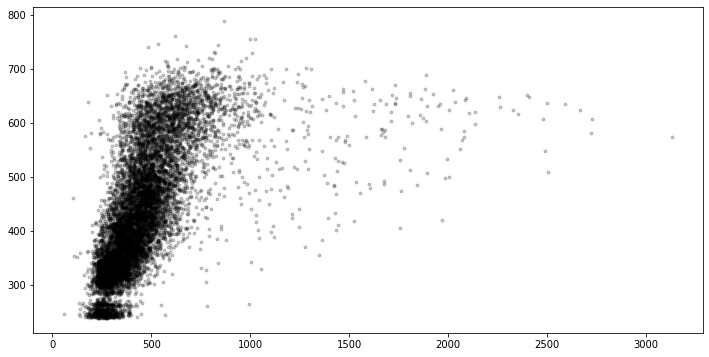

In [57]:
values = {
    "encoded" : torch.Tensor()
}
def hook(model, input, output):
    values["encoded"] = torch.cat([values["encoded"], output.detach()])

hook_handle = model.encoder.register_forward_hook(hook)
trips, preds, durations = get_predictions(model, test_dl, 5)

plt.plot(durations, preds, ".k", alpha=.2)

In [66]:
values["encoded"][:, 0].min()

tensor(0.6867)

In [ ]:
values["encoded"][:, 0]

In [69]:
model.encoder.fc3.weight

Parameter containing:
tensor([[-0.1808,  0.0336, -0.0366,  0.1682, -0.1166, -0.0040,  0.0461, -0.1905,
          0.0842, -0.3094,  0.1473, -0.0240,  0.2187,  0.0564, -0.0434, -0.2860],
        [ 0.0172, -0.3006,  0.0436, -0.0416, -0.0772, -0.1161,  0.2365,  0.0453,
         -0.0278,  0.0825, -0.0355,  0.1386, -0.0303,  0.0302, -0.0396, -0.2295],
        [-0.2330,  0.0540, -0.2173, -0.0644, -0.1239, -0.3750,  0.2764,  0.2160,
         -0.0820,  0.0421, -0.0733, -0.0899, -0.1473, -0.2305, -0.2772, -0.2276]],
       requires_grad=True)

In [72]:
newnet = HistoryEncoder(5, 3)
newnet.load_state_dict(model.encoder.state_dict())


<All keys matched successfully>

In [75]:
hist[1]

tensor([1.2036, 0.2299, 0.2139, 0.3656, 1.0839])

In [82]:
newnet(torch.Tensor([1000]*5))

tensor([0.6896, 1.3248, 0.0178], grad_fn=<AddBackward0>)

In [81]:
newnet(torch.rand(5))

tensor([0.6896, 1.3248, 0.0178], grad_fn=<AddBackward0>)

In [96]:
newnet.fc4.weight

AttributeError: 'HistoryEncoder' object has no attribute 'fc4'

In [83]:
untrained = HistoryEncoder(5, 3)

tensor([-0.1069, -0.2505, -0.1643], grad_fn=<AddBackward0>)

In [92]:
untrained(torch.Tensor([1000]*5))

tensor([ 36.3380, -54.9135,  30.7848], grad_fn=<AddBackward0>)

In [ ]:
untrained(weights)

In [71]:
model.encoder(hist[0])

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

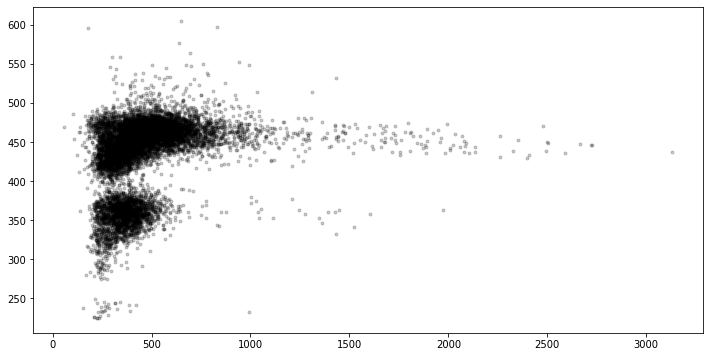

In [27]:
trips, preds, durations = get_predictions(model, test_dl, 1)
plt.plot(durations, preds, ".k", alpha=.2)

In [ ]:
plt.plot(durations[hist_lengths==1], preds[hist_lengths==1], ".k", alpha=.2)

In [ ]:
plt.plot(durations[hist_lengths==5], preds[hist_lengths==5], ".k", alpha=.2)